In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label, subfolder in enumerate(os.listdir(folder)):
        subfolder_path = os.path.join(folder, subfolder)
        for filename in os.listdir(subfolder_path):
            img = cv2.imread(os.path.join(subfolder_path, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (100, 100))  # Resizing images to the same size
                img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale images
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)


def create_pairs(images, labels):
    pairs = []
    labels_pair = []
    num_classes = len(np.unique(labels))
    
    # Create positive pairs (same class)
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] == labels[j]:
                pairs.append([images[i], images[j]])
                labels_pair.append(1)
    
    # Create negative pairs (different class)
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] != labels[j]:
                pairs.append([images[i], images[j]])
                labels_pair.append(0)
    
    return np.array(pairs), np.array(labels_pair)



In [10]:
# Step 2: Build the Siamese Network model
def build_siamese_model(input_shape):
    input_layer = layers.Input(input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    model = models.Model(input_layer, x)
    return model

# Define the distance function for Siamese network
def siamese_distance(vectors):
    vector1, vector2 = vectors
    return tf.math.abs(vector1 - vector2)

def build_full_siamese_model(input_shape):
    base_model = build_siamese_model(input_shape)
    
    input1 = layers.Input(input_shape)
    input2 = layers.Input(input_shape)
    
    output1 = base_model(input1)
    output2 = base_model(input2)
    
    distance_layer = layers.Lambda(siamese_distance)([output1, output2])
    output_layer = layers.Dense(1, activation='sigmoid')(distance_layer)
    
    siamese_model = models.Model([input1, input2], output_layer)
    
    siamese_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return siamese_model

In [11]:
# Step 3: Train the Siamese Network
def train_siamese_model(folder_path):
    images, labels = load_images_from_folder(folder_path)
    pairs, pair_labels = create_pairs(images, labels)
    
    # Split into training and test sets
    pairs_train, pairs_test, labels_train, labels_test = train_test_split(pairs, pair_labels, test_size=0.2, random_state=42)
    
    # Prepare data for the model
    input_shape = pairs_train.shape[2:]
    siamese_model = build_full_siamese_model(input_shape)
    
    siamese_model.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train, batch_size=32, epochs=10, validation_split=0.2)
    
    # Step 4: Evaluate the model
    predictions = siamese_model.predict([pairs_test[:, 0], pairs_test[:, 1]])
    predictions = (predictions > 0.5).astype(int)
    
    accuracy = accuracy_score(labels_test, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(labels_test, predictions)
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    return siamese_model




Epoch 1/10


1351/1351 [==============================] - 866s 638ms/step - loss: 0.3502 - accuracy: 0.8881 - val_loss: 0.0243 - val_accuracy: 0.9919
Epoch 2/10
1351/1351 [==============================] - 854s 632ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 4.0489e-04 - val_accuracy: 0.9998
Epoch 3/10
1351/1351 [==============================] - 854s 632ms/step - loss: 3.8687e-05 - accuracy: 1.0000 - val_loss: 5.4909e-05 - val_accuracy: 1.0000
Epoch 4/10
1351/1351 [==============================] - 848s 628ms/step - loss: 4.8783e-06 - accuracy: 1.0000 - val_loss: 4.5466e-05 - val_accuracy: 1.0000
Epoch 5/10
1351/1351 [==============================] - 869s 643ms/step - loss: 2.3779e-06 - accuracy: 1.0000 - val_loss: 3.4627e-05 - val_accuracy: 1.0000
Epoch 6/10
1351/1351 [==============================] - 913s 676ms/step - loss: 1.1760e-06 - accuracy: 1.0000 - val_loss: 2.9594e-05 - val_accuracy: 1.0000
Epoch 7/10
1351/1351 [==============================] - 923s 683ms/step 

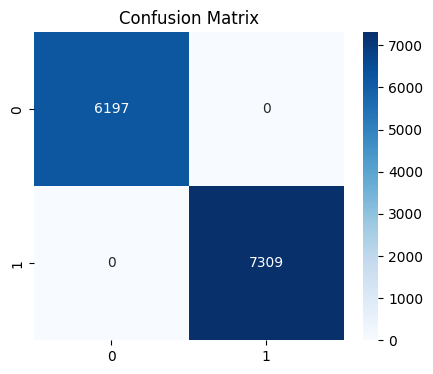

In [12]:

# Step 5: Run the model
if __name__ == "__main__":
    folder_path = "./augmented/"
    siamese_model = train_siamese_model(folder_path)